In [1]:
import scanpy as sc

In [2]:
adata=sc.read("s_fca_biohub_testis_10x.h5ad")

In [3]:
adata=adata.raw.to_adata()

In [4]:
del adata.uns

In [5]:
adata.obs=adata.obs[["annotation"]]

In [6]:
adata.var=adata.var[["ID"]]

/home/lfaure/tools/scanpy/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


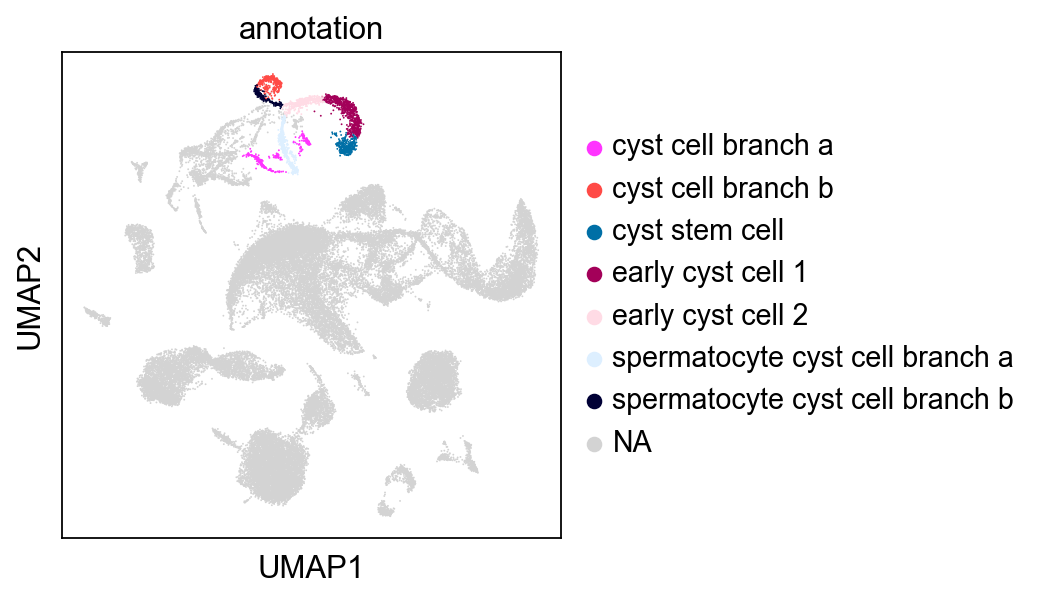

In [7]:
sc.set_figure_params()
sel=["early cyst cell 1","early cyst cell 2","cyst cell branch a",
     "cyst cell branch b",
     "cyst stem cell","spermatocyte cyst cell branch a","spermatocyte cyst cell branch b"]
sc.pl.umap(adata,color="annotation",groups=sel)

In [8]:
adata=adata[adata.obs.annotation.isin(sel)]

In [9]:
import scFates as scf

In [10]:
scf.pp.diffusion(adata)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


Running Diffusion maps 
Determing nearest neighbor graph...


/home/lfaure/miniconda3/envs/rapids-22.06/lib/python3.8/site-packages/palantir/utils.py:55: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)
/home/lfaure/miniconda3/envs/rapids-22.06/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    determining multiscale diffusion space
    finished (0:00:07) --> added 
    .obsm['X_diffusion_multiscale'], multiscale diffusion space.


In [11]:
sc.pp.neighbors(adata,n_neighbors=100,method="rapids")

In [12]:
sc.tl.draw_graph(adata,init_pos='X_umap',method="rapids")

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


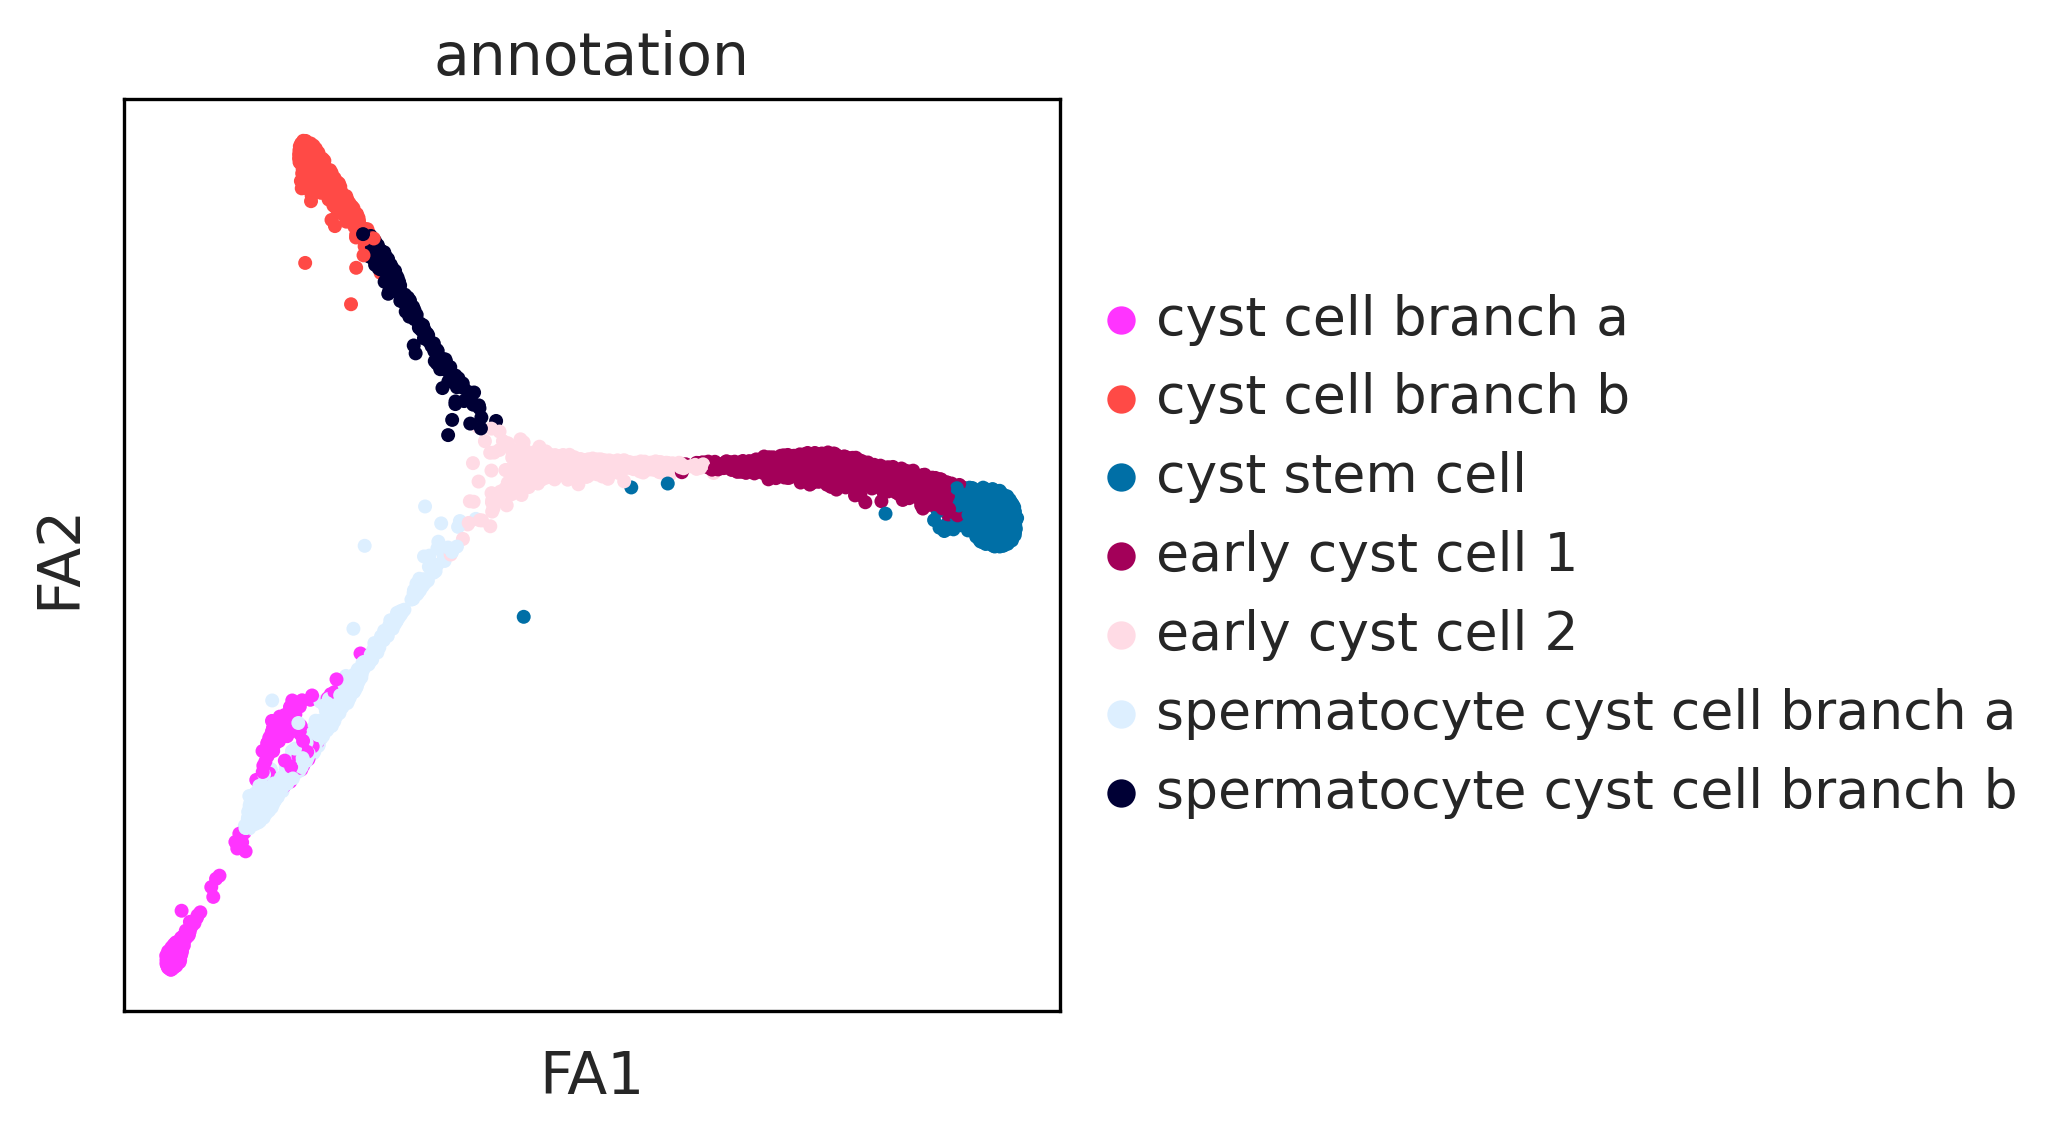

In [13]:
sc.set_figure_params(dpi=150)
sc.pl.draw_graph(adata,color="annotation")

In [14]:
scf.tl.tree(adata,Nodes=500,method="ppt",use_rep="X_diffusion_multiscale",seed=42,ppt_lambda=100,ppt_sigma=.2)

inferring a principal tree inferring a principal tree --> parameters used 
    500 principal points, sigma = 0.2, lambda = 100, metric = euclidean
    fitting: 100%|██████████| 50/50 [01:55<00:00,  2.31s/it]
    not converged (error: 0.005750766048277201)
    finished (0:01:55) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


    graph cleaned --> removed 21 principal points


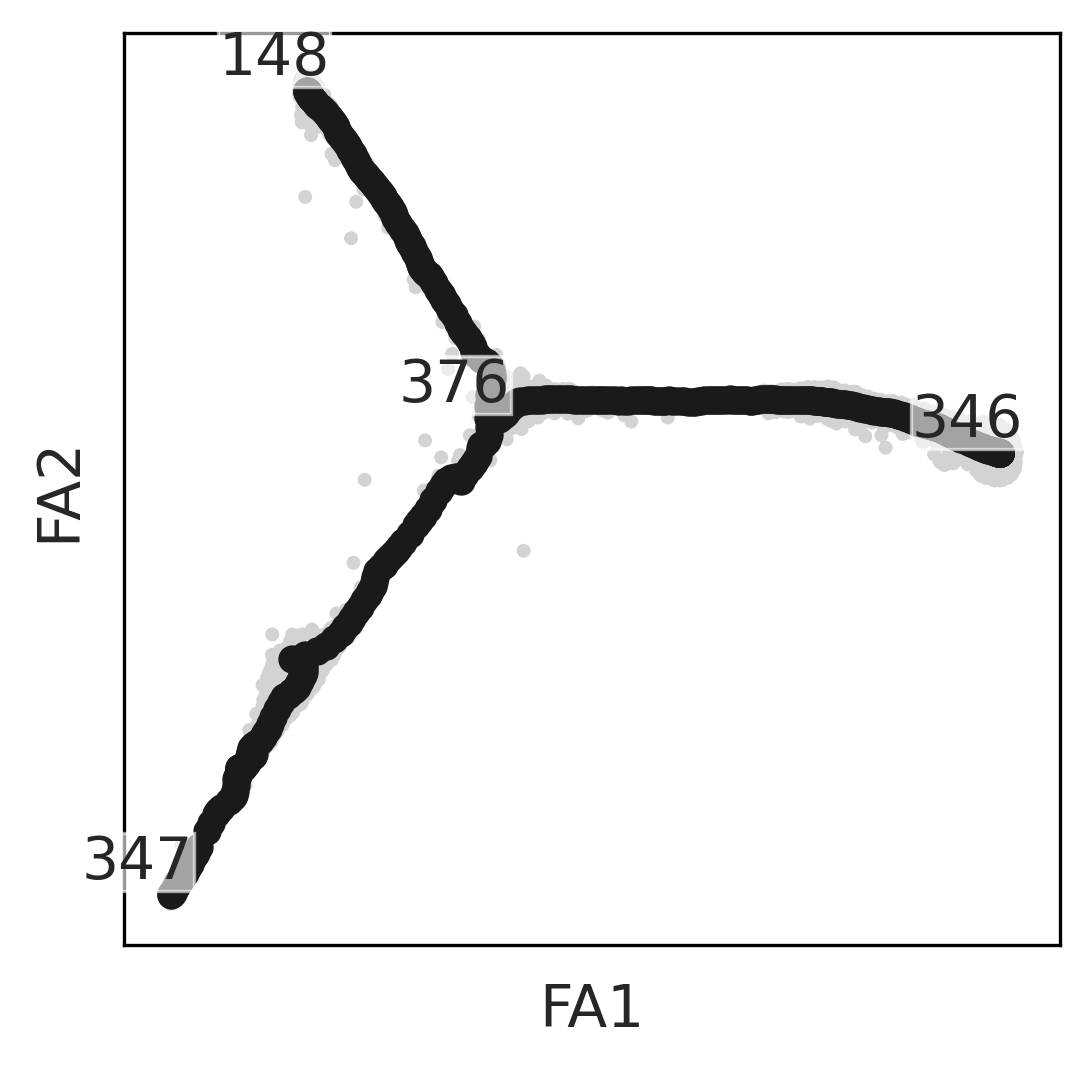

In [15]:
scf.tl.cleanup(adata,leaves=[431])
scf.pl.graph(adata,basis="draw_graph_fa")

In [16]:
scf.tl.root(adata,346)

node 346 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [17]:
scf.tl.pseudotime(adata,n_jobs=40,n_map=100)

projecting cells onto the principal graph
    mappings: 100%|██████████| 100/100 [00:49<00:00,  2.00it/s]
    finished (0:00:52) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


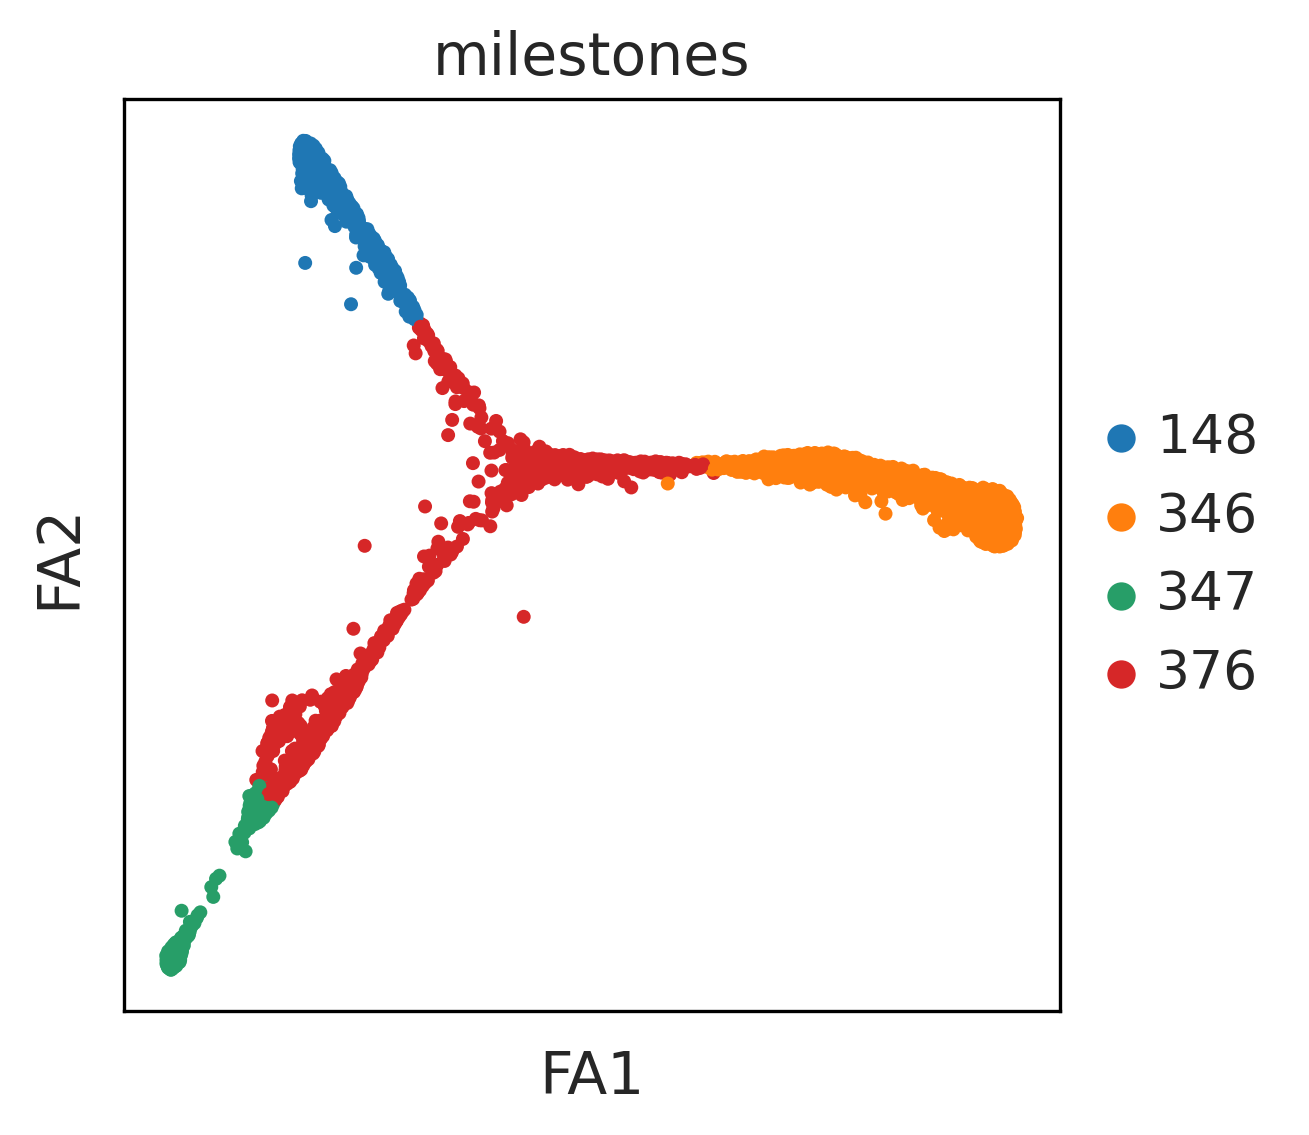

In [18]:
sc.pl.draw_graph(adata,color="milestones")

In [19]:
scf.tl.rename_milestones(adata,["B","stem","A","bifurcation"])

In [20]:
import numpy as np
adata.X.data=np.expm1(adata.X.data)

In [21]:
sc.pp.log1p(adata,base=10)

In [22]:
scf.tl.test_association(adata,n_jobs=40)

test features for association with the trajectory
    single mapping : 100%|██████████| 15695/15695 [02:31<00:00, 103.72it/s]
    found 126 significant features (0:02:31) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [23]:
scf.tl.test_association(adata,reapply_filters=True,A_cut=.2)

reapplied filters, 2135 significant features


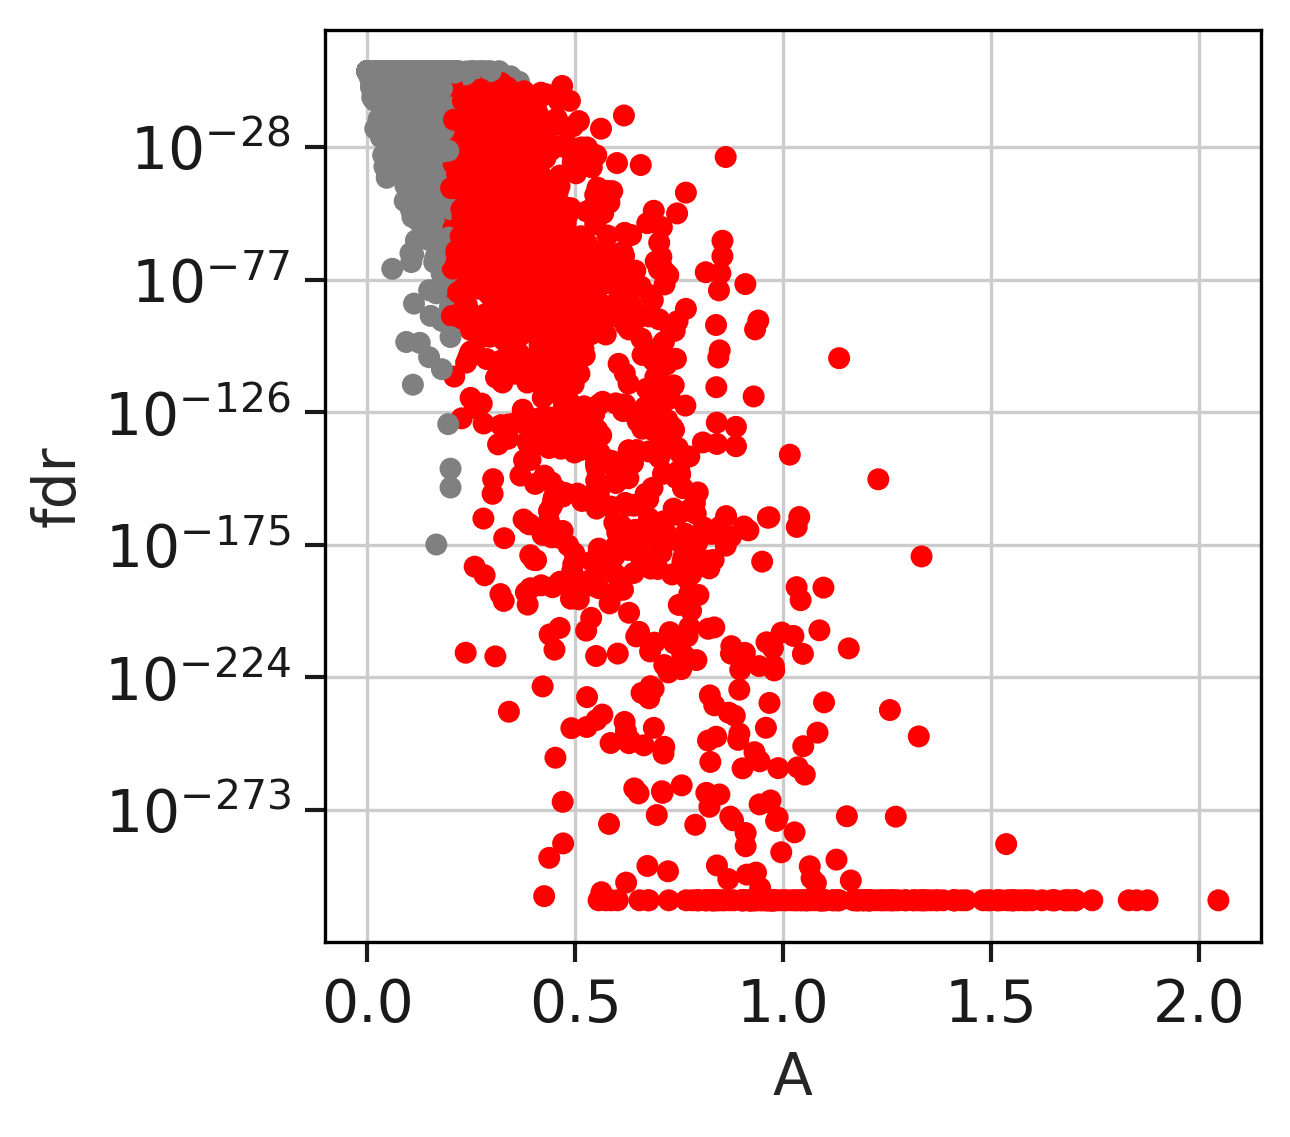

In [24]:
scf.pl.test_association(adata)

In [25]:
scf.tl.fit(adata,n_jobs=40)

fit features associated with the trajectory
    single mapping : 100%|██████████| 2135/2135 [01:07<00:00, 31.43it/s]
    finished (adata subsetted to keep only fitted features!) (0:01:10) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


In [ ]:
adata.write("adata_tree.h5ad")